### Learnable and differentiable Darmois construction

The following notebook tries to implement the Darmois construction in a way such that it is:
- (partially) learnable from data using a normalizing flow;
- differentiable.

We will make extensive use of the Jax package for Normalizing Flows developed by Chris Waites and available here:

https://github.com/ChrisWaites/jax-flows

In [1]:
import jax
from jax import numpy as np
import matplotlib.pyplot as plt

### 1. Data generation

As a first step, as usual, I will generate the data.

In [2]:
def f_1(x, y):
    "Moderately nonlinear mixing"
    f0 = np.tanh(4*x - 2) + x + y/2
    f1 = np.tanh(4*y - 2) + y + x/2
    return f0, f1

In [3]:
# N:=Number of samples
N = 3000
# D:=Number of dimensions
D = 2

In [4]:
from jax import random
key = random.PRNGKey(0)

S = random.uniform(key, shape=(D, N), minval=0.0, maxval=1.0)

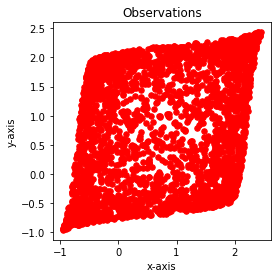

In [5]:
# Apply mixing
X_0, X_1 = f_1(S[0], S[1])

# Plot observations
plt.scatter(X_0, X_1, color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [6]:
X = np.vstack([X_0, X_1]).T

Now define the autoregressive model we will use to learn the Darmois construction.

In [7]:
import sys
sys.path.append('/Users/luigigresele/git/existing_projects/jax-flows')

In [8]:
import flows

from jax import grad, jit, random
from jax.experimental import stax, optimizers

In [9]:
rng, flow_rng = random.split(random.PRNGKey(0))
input_dim = X.shape[1]
num_epochs, batch_size = 500, 50

Now it's time to construct the normalizing flow model. We'll opt for `MAF` composed of a sequence of 5 blocks.

In [10]:
def get_masks(input_dim, hidden_dim=64, num_hidden=1):
    masks = []
    input_degrees = np.arange(input_dim)
    degrees = [input_degrees]

    for n_h in range(num_hidden + 1):
        degrees += [np.arange(hidden_dim) % (input_dim - 1)]
    degrees += [input_degrees % input_dim - 1]

    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [np.transpose(np.expand_dims(d1, -1) >= np.expand_dims(d0, 0)).astype(np.float32)]
    return masks

In [11]:
def masked_transform(rng, input_dim):
    masks = get_masks(input_dim, hidden_dim=64, num_hidden=1)
    act = stax.Relu
    init_fun, apply_fun = stax.serial(
        flows.MaskedDense(masks[0]),
        act,
        flows.MaskedDense(masks[1]),
        act,
        flows.MaskedDense(masks[2].tile(2)),
    )
    _, params = init_fun(rng, (input_dim,))
    return params, apply_fun

In [12]:
init_fun = flows.Flow(
    flows.Serial(*(flows.MADE(masked_transform), flows.Reverse()) * 5),
    flows.Normal()
)

In [13]:
params, log_pdf, sample = init_fun(flow_rng, input_dim)

Now, given the model, we can start to optimize it. We can do this by creating a regular JAX Adam optimizer, supplying it the model parameters.

In [14]:
opt_init, opt_update, get_params = optimizers.adam(step_size=5*1e-5)
opt_state = opt_init(params)

In [15]:
from tqdm.notebook import trange
import itertools
import numpy.random as npr

Now we'll define the loss we'd like to minimize, as well as the step function which will update our parameters given a batch and compile it.

In [16]:
def loss(params, inputs):
    return -log_pdf(params, inputs).mean()

@jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)
    gradients = grad(loss)(params, inputs)
    return opt_update(i, gradients, opt_state)

And now we train!

In [17]:
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
from IPython.display import clear_output
import jax.numpy as np

%matplotlib inline

Training starts here (runtime: approx 3 minutes on my laptop.)

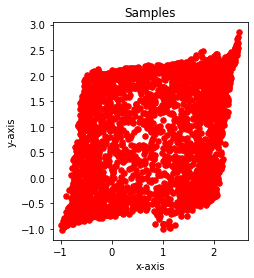

In [18]:
itercount = itertools.count()

for epoch in range(num_epochs):
    clear_output(wait=True) # Clear plotting

    permute_rng, rng = random.split(rng)
    X = random.permutation(permute_rng, X)
    for batch_index in range(0, len(X), batch_size):
        opt_state = step(next(itercount), opt_state, X[batch_index:batch_index+batch_size])
     
    params = get_params(opt_state)
    sample_rng, rng = random.split(rng)
    X_syn = sample(rng, params, X.shape[0])
    
#     plt.hist2d(X_syn[:, 0], X_syn[:, 1], bins=n_bins, range=plot_range)
#     plt.show()
    plt.scatter(X_syn[:,0], X_syn[:,1], color='r', s=30)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.title('Samples')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

params = get_params(opt_state)

The function `log_pdf` returns the log-pdf of the latent projections; we need to extract the forward (and possibly inverse) function alone.

In [19]:
# Forward function
init_forward_pass =  flows.Serial(*(flows.MADE(masked_transform), flows.Reverse()) * 5)
_, direct_fun, inverse_fun = init_forward_pass(flow_rng, input_dim)

Let's look at the distribution of the latent variables.

In [20]:
Y = direct_fun(params, X)[0]

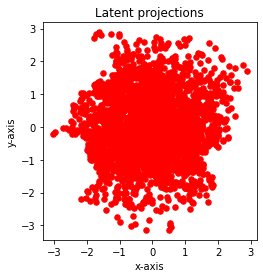

In [21]:
plt.scatter(Y[:,0], Y[:,1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Latent projections')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

The latent projections are learned s.t. they maximize a Gaussian likelihood. In order to match the output expected by the Darmois construction, we need to apply a CDF transform on top to turn them into uniform random variables.

In [22]:
Y_ = jax.scipy.stats.norm.cdf(Y)

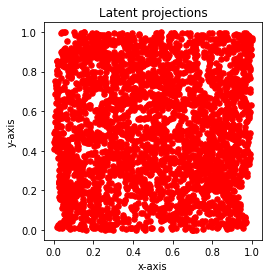

In [23]:
plt.scatter(Y_[:,0], Y_[:,1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Latent projections')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

They indeed almost follow a uniform distribution; deviations might be due to imperfect training? Maybe better with a longer training time?

Additional sanity check --- check that the inverse function matches the observations well.

In [24]:
X_hat = inverse_fun(params, Y)[0]

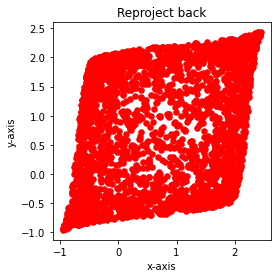

In [25]:
plt.scatter(X_hat[:,0], X_hat[:,1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Reproject back')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

We will now color the latent sources, in order to have a visual understanding of the distortions induced by the mixing function and by the composition of the mixing with the Darmois construction.

In [26]:
S = S.T

In [27]:
# Plotting 

import cmocean

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

_, phi = cart2pol( S[:, 0]-0.5, S[:,1]-0.5)

colors = phi

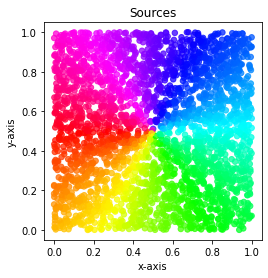

In [28]:
# Plot sources
plt.scatter(S[:,0], S[:,1], c=colors, s=30, alpha=0.75, cmap='hsv')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Sources')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

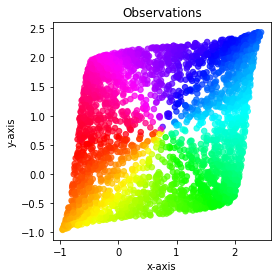

In [29]:
# Apply mixing
X_0, X_1 = f_1(S[:, 0], S[:, 1])

# Plot observations
plt.scatter(X_0, X_1, c=colors, s=30, alpha=0.75, cmap='hsv')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [30]:
X = np.vstack([X_0, X_1]).T
X.shape

(3000, 2)

Apply our learnt Darmois construction (autoregressive flow plus the CDF transform).

In [31]:
# Learnt normalizing flow
Y = direct_fun(params, X)[0]
# CDF transform
Y_ = jax.scipy.stats.norm.cdf(Y)

Plot the resulting latent variables

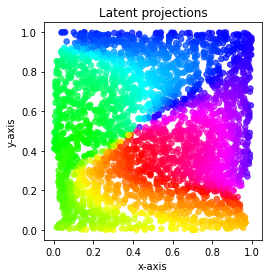

In [32]:
plt.scatter(Y_[:,0], Y_[:,1], c=colors, s=30, alpha=0.75, cmap='hsv')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Latent projections')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Additional sanity check --- check the effect of the inverse function

In [33]:
X_hat = inverse_fun(params, Y)[0]

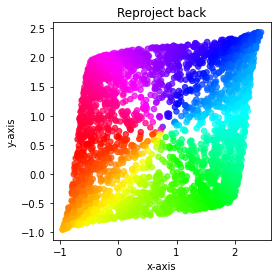

In [34]:
plt.scatter(X_hat[:,0], X_hat[:,1], c=colors, s=30, alpha=0.75, cmap='hsv')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Reproject back')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### It would be interesting to check whether this partially learnt Darmois construction is similar to the one obtained with my costum function (see notebook 0.)

**Problem:** Jax arrays do not support item assignment! Therefore my function is not compatible

**Solution:**  Create the array using `numpy` (not `jax.numpy`) imported as `onp`.

In [35]:
import numpy as onp

In [36]:
from statsmodels.distributions.empirical_distribution import ECDF

In [37]:
# Code below exactly copied from the 1st notebook!
def g_1(x):
    '''
    Takes a collection of N samples as input and returns their cdf transform
    
    Input:
    x = N dimensional array
    
    Output:
    N dimensional array
    '''
    ecdf = ECDF(x)
    return ecdf(x)

In [38]:
# Code below similar to 1st notebook --- np -> onp!
def g_darmois(X_0, X_1, bins_y=100):
    '''
    Takes two collections of N univariate samples (that is, N bivariate samples) as input and outputs the Darmois construction.
    Requires binning over the y_0=g_1(X_0, X_1) values in order to compute the **conditional** CDF
    
    Input:
    X_0 =  N dimensional array
    X_1 =  N dimensional array
    bins_y = n bins to discretize y_1
    
    Output:
    N dimensional array, N dimensional array
    '''    
    
    # Compute the 1st component of the estimated sources
    y_0 = g_1(X_0)

    # Create a 2d array with y_0 and X_1
    # The **third** row --- that is, arr[2,:] --- will be populated with the 2nd component of the estimated sources
    arr = onp.vstack([y_0, X_1, y_0])
        
    # Establish binning for y_1
    upper_limit = onp.max(y_0)
    lower_limit = onp.min(y_0)
    binning = np.linspace(lower_limit, upper_limit, num=bins_y)    
    
    # Return cdf
    for i in range(bins_y-1):
        cond1 = arr[0,:]>=binning[i]
        cond2 = arr[0,:]<binning[i+1]
        and_cond = onp.logical_and(cond1, cond2)
        ecdf = ECDF(arr[1, and_cond])
        arr[2, and_cond] = ecdf(arr[1, and_cond]) # select only the proper bins!

    return y_0, arr[2,:]

In [39]:
Y_0_darm, Y_1_darm = g_darmois(X_0, X_1, bins_y=70)

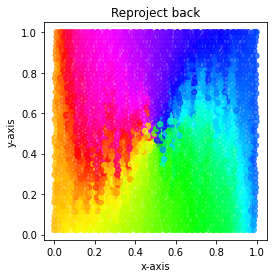

In [40]:
plt.scatter(Y_0_darm, Y_1_darm, c=colors, s=30, alpha=0.75, cmap='hsv')#cmap=cmocean.cm.phase)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Reproject back')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

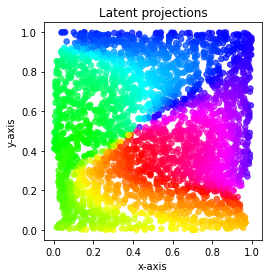

In [41]:
plt.scatter(Y_[:,0], Y_[:,1], c=colors, s=30, alpha=0.75, cmap='hsv')#cmap=cmocean.cm.phase)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Latent projections')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

The learnt solution seems to distort the space in a similar way to the custom function.

At the same time **there appears to be a problem with transposition of the dimension indices (0->1), see plot below; not sure where this comes from.**

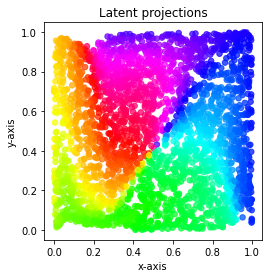

In [42]:
plt.scatter(Y_[:,1], Y_[:,0], c=colors, s=30, alpha=0.75, cmap='hsv')#cmap=cmocean.cm.phase)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Latent projections')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

This is of course a purely visual inspection and no guarantee that the two functions match.

# Notes on what is missing:

- ~~The code above gives you the forward function + log-pdf; it would be nice to be able to return the output of the forward function **alone**.~~
- ~~Moreover, it should be composed with the CDF of the base distribution to replicate the Darmois construction~~
- The composition with the CDF should be s.t. it is based on the sign of the derivative!
- **Where is the Jacobian returned (if anywhere?)** Should we compute it with autodiff for simplicity? Note that this should be computed in `flow.Flow()`